In [1]:
# Importing libraries
import numpy as np
from numpy import mean
from numpy import std

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import statsmodels.api as sm
# from patsy import dmatrices
# from statsmodels.stats.outliers_influence import variance_inflation_factor


#Visualization
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

from matplotlib.pyplot import xticks
%matplotlib inline

# Data display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

#Sci-kit learn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

#removendo Avisos
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import data (dados de ranking e dados manuais dos vendedores já removidos)
lead_read = pd.read_csv('C:/Users/mariana.blattner_ifo/Meu Drive/Documentos/Pós/TCC/Base_dados/base_dados.csv', sep=";")

#dropando inputs manuais e scores
col_drop = ['Prospect ID', 'Lead Number', 'Tags', 'Lead Quality', 'Lead Profile', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index','Asymmetrique Activity Score', 'Asymmetrique Profile Score']
lead_read_aux = lead_read.drop(col_drop, axis=1)
lead_read_aux = lead_read_aux.drop('Last Notable Activity', axis=1) #campo com alta correlação

#Substituindo select por nan
lead_nan = lead_read_aux.replace('Select', np.nan)

#Convertendo yes/no pra binário
lead_binario_no = lead_nan.replace('No', 0)
lead_binario_final = lead_binario_no.replace('Yes', 1)

In [3]:
original = lead_read.shape
tratado = lead_binario_final.shape

# lead_read.resume()
# original,tratado

In [4]:
# removendo colunas sem informação (máximo = minimo = 0)
col_drop = ["Magazine", "Receive More Updates About Our Courses","Update me on Supply Chain Content", "Get updates on DM Content", "I agree to pay the amount through cheque"]
lead_drop_colunas = lead_binario_final.drop(col_drop, axis=1) #index 0 deleta linha, index 1 deleta coluna


#removendo linhas sem dados da visita ----fora de uso, vou usar valorew mais comuns e medianas pra tratar esses dados
# lead_drop_linhas = lead_drop_colunas.loc[(lead_drop_colunas["TotalVisits"] >= 0) ]
# lead_drop_colunas.shape, lead_drop_linhas.shape

In [5]:
# columa "How did you hear about X Education" possui 78% dos dados NANe será dropada
col_drop = ["How did you hear about X Education"]
lead_drop_colunas_NAN = lead_drop_colunas.drop(col_drop, axis=1) #index 0 deleta linha, index 1 deleta coluna

# colunas categóricas trarão mediada, colunas numéricas o valor mais frequente
# https://medium.com/data-hackers/tratamento-e-transforma%C3%A7%C3%A3o-de-dados-nan-uma-vis%C3%A3o-geral-e-pr%C3%A1tica-54efa9fc7a98
col_numerica = ["TotalVisits","Page Views Per Visit"]
col_categoricas = ["Last Activity","City","Country","Specialization","What is your current occupation","What matters most to you in choosing a course"]

#função tratar NAN
median_imputer=SimpleImputer(missing_values=np.nan,strategy='median')
most_imputer=SimpleImputer(missing_values=np.nan,strategy='most_frequent')

lead_tratandoNAN = lead_drop_colunas_NAN
lead_tratandoNAN[col_numerica]=median_imputer.fit_transform(lead_tratandoNAN[col_numerica])
lead_tratandoNAN[col_categoricas]=most_imputer.fit_transform(lead_tratandoNAN[col_categoricas])

# perc_null = lead_tratandoNAN
# round(100*perc_null.isnull().sum()/perc_null.shape[0],0) , perc_null.shape

In [6]:
# padronização das variáveis
col_padronizar = ['Total Time Spent on Website','Page Views Per Visit','TotalVisits']

#função padronizar
scaler = StandardScaler()

lead_padronizada = lead_tratandoNAN
lead_padronizada[col_padronizar] = scaler.fit_transform(lead_tratandoNAN[col_padronizar])

In [7]:
# criando dummies
# removendo cidade e pais pra tentar rodar teste
dummy = pd.get_dummies(lead_padronizada[['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization', 'What is your current occupation', 'What matters most to you in choosing a course']], drop_first=True)
# dummy = pd.get_dummies(lead_padronizada[['Lead Origin', 'Lead Source', 'Last Activity', 'City', 'Country', 'Specialization', 'What is your current occupation', 'What matters most to you in choosing a course']], drop_first=True)


# add na base
lead_dummies_aux = pd.concat([lead_padronizada, dummy], axis=1)

# deletando colunas originais
lead_dummies = lead_dummies_aux.drop(['Lead Origin', 'Lead Source', 'Last Activity', 'City', 'Country', 'Specialization', 'What is your current occupation', 'What matters most to you in choosing a course'], axis=1)
# lead_dummies.head()

In [8]:
#verificando top correlações (mapa calor ficou com muitas colunas)

corr_lead = lead_dummies.corr()
corr_lead = corr_lead.where(np.triu(np.ones(corr_lead.shape),k=1).astype(np.bool))
corr_df = corr_lead.unstack().reset_index()
corr_df.columns =['VAR1','VAR2','Correlation']
corr_df.dropna(subset = ["Correlation"], inplace = True) 

#top 10 positivas 
corr_df.sort_values(by='Correlation', ascending=False, inplace=True)
# corr_df.head(10)

In [9]:
# https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/
# We need to set an absolute value, say 0.5 as the threshold for selecting the variables. 
# If we find that the predictor variables are correlated among themselves, we can drop the variable which has a 
# lower correlation coefficient value with the target variable. We can also compute multiple correlation 
# coefficients to check whether more than two variables are correlated to each other. 
# This phenomenon is known as multicollinearity.

# deletando colunas das correlações 
lead_dummies_correlacao_final = lead_dummies.drop(["Lead Source_Facebook",
"Newspaper Article",
"Do Not Email",
"A free copy of Mastering The Interview",
"Lead Origin_Landing Page Submission",
"Page Views Per Visit",
"What is your current occupation_Unemployed",
"Last Activity_Email Opened"], axis=1)

# lead_dummies_correlacao_final.head()


In [10]:
lead_dummies_correlacao_final.shape

(9240, 69)

# Selecionando features

In [11]:
col_final = [
'Lead Source_Olark Chat',
'Lead Origin_Lead Add Form',
'Last Activity_Olark Chat Conversation',
'Lead Source_Welingak Website',
'Total Time Spent on Website',
'Last Activity_SMS Sent',
'What is your current occupation_Working Professional',
'Last Activity_Email Link Clicked',
'Last Activity_Email Bounced',
'Last Activity_Had a Phone Conversation',
'Last Activity_Page Visited on Website',
'Specialization_Hospitality Management',
'Last Activity_Converted to Lead',
'Last Activity_Form Submitted on Website',
'Converted'
]

col_final_2 = [
'Lead Source_Olark Chat',
'Lead Origin_Lead Add Form',
'Last Activity_Olark Chat Conversation',
'Lead Source_Welingak Website',
'Total Time Spent on Website',
'Last Activity_SMS Sent',
'What is your current occupation_Working Professional',
'Last Activity_Email Link Clicked',
'Last Activity_Email Bounced',
'Last Activity_Had a Phone Conversation',
'Last Activity_Page Visited on Website',
'Specialization_Hospitality Management',
'Last Activity_Converted to Lead',
'Last Activity_Form Submitted on Website'
]

In [12]:
lead = lead_dummies_correlacao_final[col_final]

In [13]:
lead.head(10)

,Lead Source_Olark Chat,Lead Origin_Lead Add Form,Last Activity_Olark Chat Conversation,Lead Source_Welingak Website,Total Time Spent on Website,Last Activity_SMS Sent,What is your current occupation_Working Professional,Last Activity_Email Link Clicked,Last Activity_Email Bounced,Last Activity_Had a Phone Conversation,Last Activity_Page Visited on Website,Specialization_Hospitality Management,Last Activity_Converted to Lead,Last Activity_Form Submitted on Website,Converted
0,1,0,0,0,-0.889974,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0.339972,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1.905689,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,-0.333396,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1.715905,0,0,0,0,0,0,0,1,0,1
5,1,0,1,0,-0.889974,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,2.102772,0,0,0,0,0,0,0,0,0,1
7,1,0,1,0,-0.889974,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,-0.760410,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,-0.784133,0,0,0,0,0,0,0,0,0,0


# Treinando o modelo

In [14]:
y = lead['Converted']
X = lead.drop(['Converted'], axis=1)

# Separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
model = GradientBoostingClassifier()

In [15]:
# fit the model with the training data
model.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [16]:
# predict the target on the train dataset
predict_train = model.predict(X_train)
predict_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [17]:
trainaccuracy = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', trainaccuracy)

accuracy_score on train dataset :  0.8324056895485467


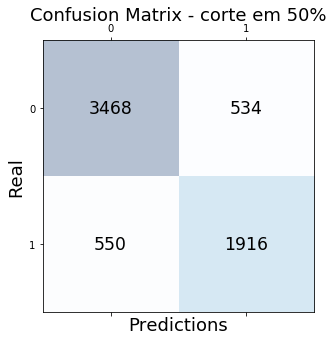

In [18]:
#Plotting the Confusion Matrix
# confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
confusion = metrics.confusion_matrix(y_train,predict_train)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confusion, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        ax.text(x=j, y=i,s=confusion[i, j], va='center', ha='center', size='xx-large')
        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Real', fontsize=18)
plt.title('Confusion Matrix - corte em 50%', fontsize=18)
plt.show()


In [19]:
# Create a matrix to Print the Accuracy, Sensitivity and Specificity
def lg_metrics(confusion_matrix):
    TN =confusion_matrix[0,0]
    TP =confusion_matrix[1,1]
    FP =confusion_matrix[0,1]
    FN =confusion_matrix[1,0]
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    speci = TN/(TN+FP)
    sensi = TP/(TP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN) #revocação
    TPR = TP/(TP + FN)
    TNR = TN/(TN + FP)
    FPR = FP/(TN + FP)
    FNR = FN/(TP + FN)
    pos_pred_val = TP /(TP+FP)
    neg_pred_val = TN /(TN+FN)
    testF1_score= 2 * (precision * recall) / (precision + recall)
    
    print ("Accuracy:    ", round(accuracy*100,2),"%")
    print ("Sensitivity: ", round(sensi*100,2),"%")
    print ("Specificity: ", round(speci*100,2),"%")
    print ("Precision:   ", round(precision*100,2),"%")
    print ("Recall:      ", round(recall*100,2),"%")
    print ("F1 Score:    ", round(testF1_score*100,2),"%")
    print ("")
    print ("True Positive Rate (TP):  ", round(TPR*100,2),"%")
    print ("False Positive Rate (FP): ", round(FPR*100,2),"%")
    print ("")
    print ("True Negative Rate (TN):  ", round(TNR*100,2),"%")
    print ("False Negative Rate (FN): ", round(FNR*100,2),"%")
    print ("")    
    print ("Positive predictive value: ", round(pos_pred_val*100,2),"%")
    print ("Negative predictive value: ", round(neg_pred_val*100,2),"%")
    
# Plotando tabela
# conf_matrix1 = confusion_matrix(y_train_pred_final['Converted'], y_train_pred_final['predicted'] )
conf_matrix1 = confusion_matrix(y_train,predict_train)
lg_metrics(conf_matrix1)



Accuracy:     83.24 %
Sensitivity:  77.7 %
Specificity:  86.66 %
Precision:    78.2 %
Recall:       77.7 %
F1 Score:     77.95 %

True Positive Rate (TP):   77.7 %
False Positive Rate (FP):  13.34 %

True Negative Rate (TN):   86.66 %
False Negative Rate (FN):  22.3 %

Positive predictive value:  78.2 %
Negative predictive value:  86.31 %


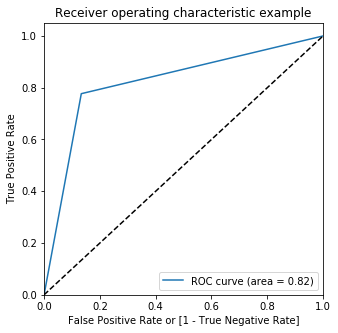

In [20]:
# Plotting the ROC Curve
# An ROC curve demonstrates several things:

# It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by 
# a decrease in specificity).
# The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
# The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.


def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

# confusion_matrix(y_train,predict_train)
# fpr, tpr, thresholds = metrics.roc_curve(y_train_pred_final.Converted, 
#                                          y_train_pred_final.Converted_prob, drop_intermediate = False )

# draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_prob)

fpr, tpr, thresholds = metrics.roc_curve(y_train, predict_train, drop_intermediate = False)

draw_roc(y_train, predict_train)

# Teste - (avaliando o treino)

In [21]:
X_test.head(5)

,Lead Source_Olark Chat,Lead Origin_Lead Add Form,Last Activity_Olark Chat Conversation,Lead Source_Welingak Website,Total Time Spent on Website,Last Activity_SMS Sent,What is your current occupation_Working Professional,Last Activity_Email Link Clicked,Last Activity_Email Bounced,Last Activity_Had a Phone Conversation,Last Activity_Page Visited on Website,Specialization_Hospitality Management,Last Activity_Converted to Lead,Last Activity_Form Submitted on Website
4269,0,0,0,0,0.954944,1,0,0,0,0,0,0,0,0
2376,0,1,0,0,-0.889974,1,0,0,0,0,0,0,0,0
7766,0,0,0,0,-0.782308,0,1,0,0,0,0,0,0,0
9199,1,0,1,0,-0.889974,0,0,0,0,0,0,0,0,0
4359,0,1,0,0,-0.889974,0,0,0,0,0,0,0,0,0


In [22]:
# Selecting only the columns used in final model of Train Dataset
X_test = X_test[col_final_2]
X_test.head()

,Lead Source_Olark Chat,Lead Origin_Lead Add Form,Last Activity_Olark Chat Conversation,Lead Source_Welingak Website,Total Time Spent on Website,Last Activity_SMS Sent,What is your current occupation_Working Professional,Last Activity_Email Link Clicked,Last Activity_Email Bounced,Last Activity_Had a Phone Conversation,Last Activity_Page Visited on Website,Specialization_Hospitality Management,Last Activity_Converted to Lead,Last Activity_Form Submitted on Website
4269,0,0,0,0,0.954944,1,0,0,0,0,0,0,0,0
2376,0,1,0,0,-0.889974,1,0,0,0,0,0,0,0,0
7766,0,0,0,0,-0.782308,0,1,0,0,0,0,0,0,0
9199,1,0,1,0,-0.889974,0,0,0,0,0,0,0,0,0
4359,0,1,0,0,-0.889974,0,0,0,0,0,0,0,0,0


In [23]:
#adding contant value
X_test_sm = sm.add_constant(X_test)
X_test_sm.columns

Index(['const', 'Lead Source_Olark Chat', 'Lead Origin_Lead Add Form',
       'Last Activity_Olark Chat Conversation', 'Lead Source_Welingak Website',
       'Total Time Spent on Website', 'Last Activity_SMS Sent',
       'What is your current occupation_Working Professional',
       'Last Activity_Email Link Clicked', 'Last Activity_Email Bounced',
       'Last Activity_Had a Phone Conversation',
       'Last Activity_Page Visited on Website',
       'Specialization_Hospitality Management',
       'Last Activity_Converted to Lead',
       'Last Activity_Form Submitted on Website'],
      dtype='object')

In [24]:
X_test_sm

,const,Lead Source_Olark Chat,Lead Origin_Lead Add Form,Last Activity_Olark Chat Conversation,Lead Source_Welingak Website,Total Time Spent on Website,Last Activity_SMS Sent,What is your current occupation_Working Professional,Last Activity_Email Link Clicked,Last Activity_Email Bounced,Last Activity_Had a Phone Conversation,Last Activity_Page Visited on Website,Specialization_Hospitality Management,Last Activity_Converted to Lead,Last Activity_Form Submitted on Website
4269,1.0,0,0,0,0,0.954944,1,0,0,0,0,0,0,0,0
2376,1.0,0,1,0,0,-0.889974,1,0,0,0,0,0,0,0,0
7766,1.0,0,0,0,0,-0.782308,0,1,0,0,0,0,0,0,0
9199,1.0,1,0,1,0,-0.889974,0,0,0,0,0,0,0,0,0
4359,1.0,0,1,0,0,-0.889974,0,0,0,0,0,0,0,0,0
9186,1.0,0,0,0,0,0.226831,1,0,0,0,0,0,0,0,0
1631,1.0,0,0,0,0,0.958594,0,0,0,0,0,0,0,0,0
8963,1.0,0,0,0,0,-0.400915,0,0,0,0,0,0,0,0,0
8007,1.0,0,0,0,0,-0.262227,0,0,0,0,0,0,0,1,0
5324,1.0,0,0,0,0,-0.597998,1,0,0,0,0,0,0,0,0


In [25]:
# Predicting the final test model 
predict_test = model.predict(X_test)
predict_test

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [26]:
#Print the Accuracy, Sensitivity and Specificity
conf_matrix = confusion_matrix(y_test, predict_test)
lg_metrics(conf_matrix)

# conf_matrix1 = confusion_matrix(y_train,predict_train)

Accuracy:     81.6 %
Sensitivity:  76.16 %
Specificity:  85.15 %
Precision:    77.01 %
Recall:       76.16 %
F1 Score:     76.58 %

True Positive Rate (TP):   76.16 %
False Positive Rate (FP):  14.85 %

True Negative Rate (TN):   85.15 %
False Negative Rate (FN):  23.84 %

Positive predictive value:  77.01 %
Negative predictive value:  84.55 %


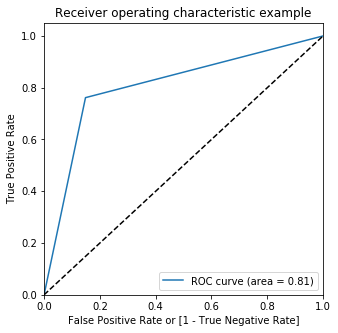

In [27]:
# ROC curve
draw_roc(y_test, predict_test)

In [28]:
from sklearn.model_selection import cross_val_score
# model = logreg
scores = cross_val_score(model, X_train, y_train, cv = 10, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))

# compute Average cross-validation score
print('')
print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Cross-validation scores:[0.81944444 0.84876543 0.82843895 0.80989181 0.82380216 0.81916538
 0.79876161 0.8250774  0.82198142 0.82352941]

Average cross-validation score: 0.8219
